<a href="https://colab.research.google.com/github/radoslaw626/TinyVGG/blob/main/TinyVGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Data downloading, preparation and analysis


In [1]:
import torch
from torch import nn

torch.__version__

'2.2.1+cu121'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd drive/MyDrive/Git/TinyVGG
!ls

/content/drive/MyDrive/Git/TinyVGG
data  models  README.md  results  scripts  TinyVGG.ipynb


In [4]:
import os

if not os.path.exists('scripts'):
    os.makedirs('scripts')

if not os.path.exists('results'):
    os.makedirs('results')

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

##1.1 Downloading data for training and testing

In [6]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path}  directory already exists")
else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("downloading pizza, steak, sushi data")
  f.write(request.content)

with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("unzipping")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi  directory already exists
downloading pizza, steak, sushi data
unzipping


In [7]:
import os
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"there are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

In [8]:
walk_through_dir(image_path)

there are 2 directories and 0 images in data/pizza_steak_sushi
there are 3 directories and 0 images in data/pizza_steak_sushi/test
there are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza
there are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
there are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
there are 3 directories and 0 images in data/pizza_steak_sushi/train
there are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza
there are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
there are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi


In [9]:
train_dir = image_path / "train"
test_dir = image_path / "test"
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [10]:
import random
from PIL import Image

# random.seed(42)

image_path_list = list(image_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

print(image_class)

img = Image.open(random_image_path)

print(f"random image path: {random_image_path}")
img, img.size

sushi
random image path: data/pizza_steak_sushi/test/sushi/175783.jpg


(<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x382>, (512, 382))

(382, 512, 3)


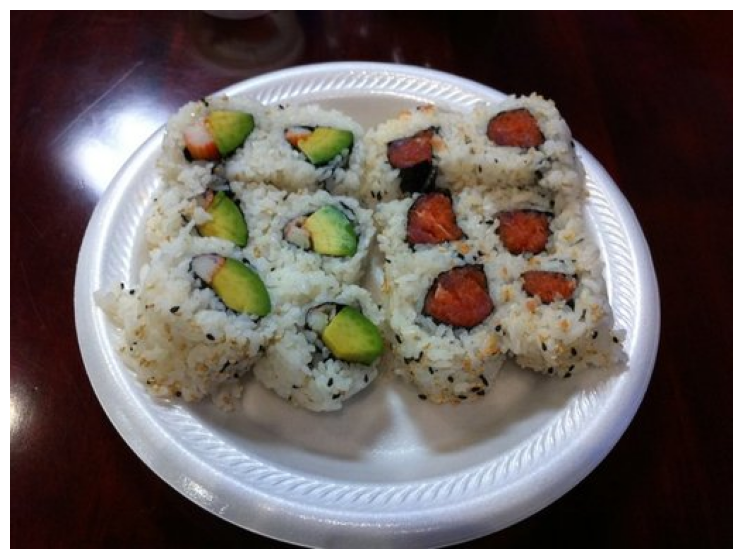

In [11]:
import matplotlib.pyplot as plt
import numpy as np

img_as_array = np.asarray(img)
plt.figure(figsize=(10,7))
plt.axis(False)
print(img_as_array.shape)
plt.imshow(img_as_array)

##1.2 Transformation of data

In [12]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [13]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [14]:
data_transform(img).shape

torch.Size([3, 64, 64])

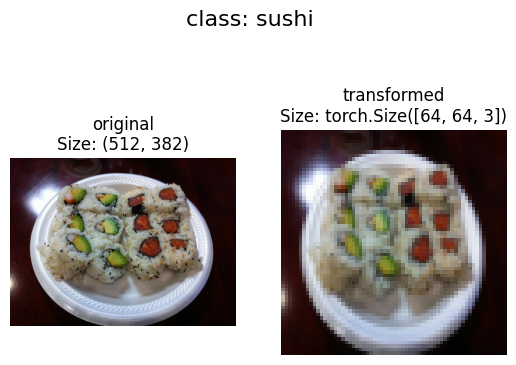

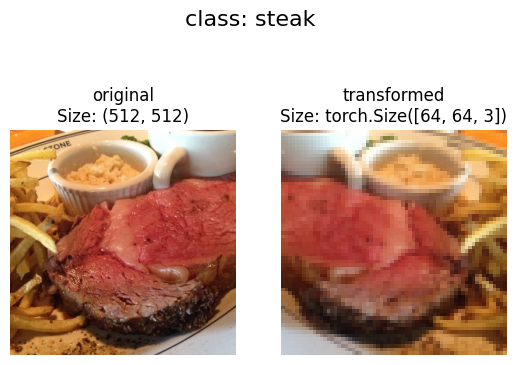

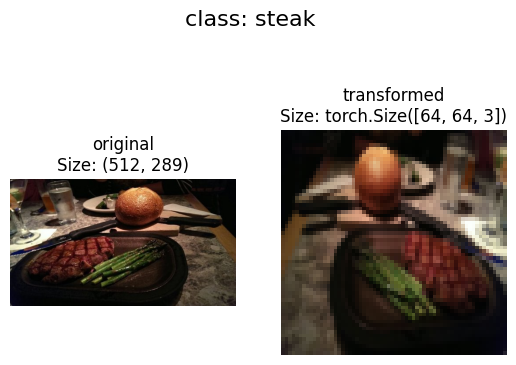

In [15]:
def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"original\nSize: {f.size}")
      ax[0].axis(False)

      transformed_image = transform(f).permute(1, 2, 0)

      ax[1].imshow(transformed_image)
      ax[1].set_title(f"transformed\nSize: {transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3)

##1.3 Analysis of data and testing

In [16]:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir,
                                  transform=data_transform)


train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [17]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [18]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [19]:
len(train_data), len(test_data)

(225, 75)

In [20]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [21]:
img, label = train_data[0][0], train_data[0][1]
print(f"image tensor: {img}")
print(f"image shape: {img.shape}")
print(f"image datatype: {img.dtype}")
print(f"image label: {label}")
print(f"image datatype: {type(label)}")

image tensor: tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.09

original shape: torch.Size([3, 64, 64])
permute shape: torch.Size([64, 64, 3])


Text(0.5, 1.0, 'pizza')

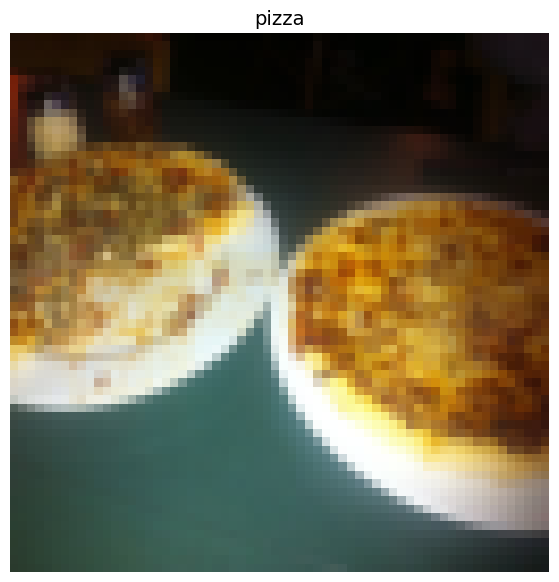

In [22]:
img_permute = img.permute(1, 2, 0)

print(f"original shape: {img.shape}")
print(f"permute shape: {img_permute.shape}")


plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis(False)
plt.title(class_names[label], fontsize=14)

In [23]:
import os
os.cpu_count()

2

In [24]:
from torch.utils.data import DataLoader

BATCH_SIZE=1
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              num_workers=1,
                              shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7ab2be8eb1f0>,
 <torch.utils.data.dataloader.DataLoader at 0x7ab2be8eb490>)

In [25]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [26]:
img, label = next(iter(train_dataloader))

print(f"image shape: {img.shape}")
print(f"label shape: {label.shape}")

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


image shape: torch.Size([1, 3, 64, 64])
label shape: torch.Size([1])


In [27]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [28]:
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [29]:
target_directory = train_dir
print(f"target dir: {target_directory}")

class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found


target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [30]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  if not classes:
    raise FileNotFoundError(f"could not find any classes in {directory}")

  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  return classes, class_to_idx


In [31]:
find_classes(str(target_directory))

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [32]:
from torch.utils.data import Dataset

class ImageFolderCustom(Dataset):
  def __init__(self,
               targ_dir: str,
               transform=None):
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    self.transform = transform
    self.classes, self.class_to_idx = find_classes(targ_dir)

  def load_image(self, index: int) -> Image.Image:
    image_path = self.paths[index]
    return Image.open(image_path)

  def __len__(self) -> int:
    return len(self.paths)

  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    img = self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.class_to_idx[class_name]

    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx

In [33]:
train_transforms = transforms.Compose([transforms.Resize(size=(64, 64)),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.ToTensor()])

test_transforms = transforms.Compose([transforms.Resize(size=(64, 64)),
                                      transforms.ToTensor()])

In [34]:
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                      transform=test_transforms)
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7ab2a0a83430>,
 <__main__.ImageFolderCustom at 0x7ab2a0a83a60>)

In [35]:
len(train_data), len(train_data_custom)

(225, 225)

In [36]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [37]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [38]:
print(train_data_custom.classes==train_data.classes)
print(test_data_custom.classes==test_data.classes)

True
True


In [39]:
def display_random_images (dataset: torch.utils.data.Dataset,
                           classes: List[str] = None,
                           n: int = 10,
                           display_shape: bool = True,
                           seed: int = None):
  if n > 10:
    n=10
    display_shape = False
    print(f"for display purposes n shouldnt be larger than 10")

  if seed:
    random.seed(seed)

  random_samples_idx = random.sample(range(len(dataset)), k=n)

  plt.figure(figsize=(16, 8))

  for i, targ_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    targ_image_adjust = targ_image.permute(1, 2, 0)

    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)

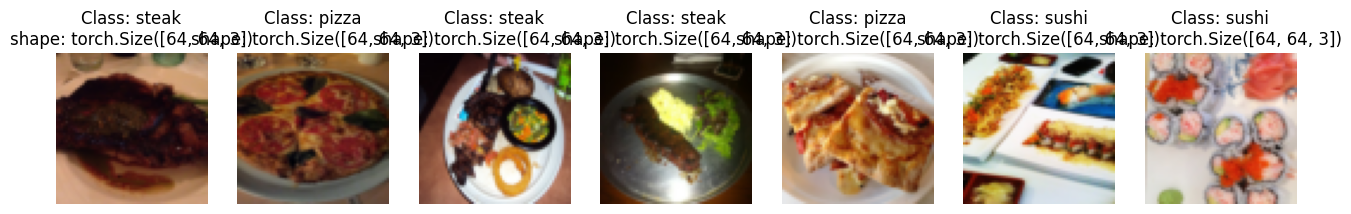

In [40]:
display_random_images(train_data,
                      n=7,
                      classes=class_names,
                      seed=None)

In [41]:
from torch.utils.data import DataLoader
BATCH_SIZE=32

train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=0,
                                     shuffle=True)
test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=0,
                                     shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7ab2a08e39a0>,
 <torch.utils.data.dataloader.DataLoader at 0x7ab2a0af80d0>)

In [42]:
img_custom, label_custom = next(iter(train_dataloader_custom))

img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [43]:
from torchvision import transforms

train_transform = transforms.Compose([
                                      transforms.Resize(size=(224, 224)),
                                      transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                      transforms.ToTensor()
])

test_transform = transforms.Compose([
                                      transforms.Resize(size=(224, 224)),
                                      transforms.ToTensor()
])

In [44]:
image_path

PosixPath('data/pizza_steak_sushi')

In [45]:
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/test/pizza/540882.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/714866.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/194643.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/3092704.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/2236338.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/309892.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/1925494.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/2124579.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/2019408.jpg'),
 PosixPath('data/pizza_steak_sushi/test/pizza/344397.jpg')]

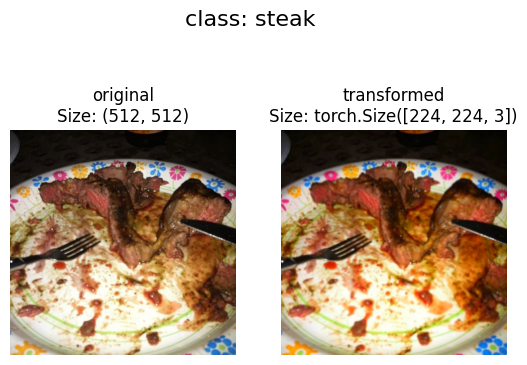

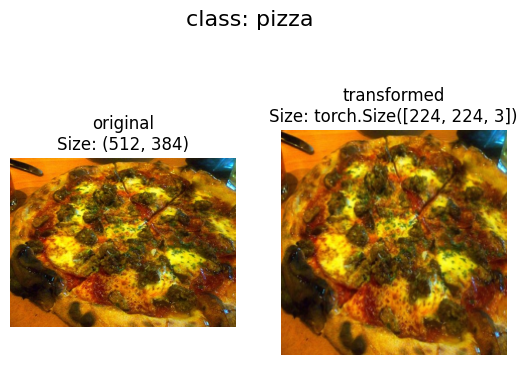

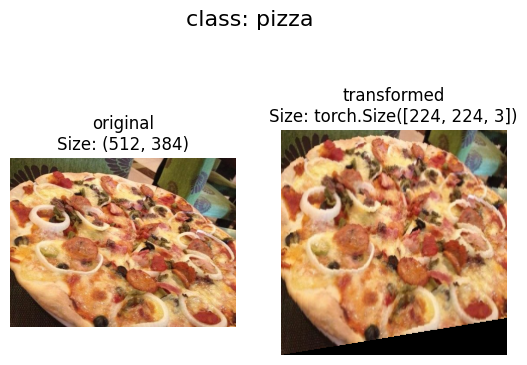

In [46]:
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transform,
    n=3,
    seed=None
)

#2. Preparation of scripts


##2.1 Data setup

In [47]:
%%writefile scripts/data_setup.py

import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
  train_dir: str,
  test_dir: str,
  train_transform: transforms.Compose,
  test_transform: transforms.Compose,
  batch_size: int,
  num_workers: int=NUM_WORKERS
):

  """
  Creates DataLoader objects for training and testing datasets.

  This function initializes DataLoader objects for both training and testing datasets using the ImageFolder class
  from torchvision. It applies the specified transformations to the images and organizes them into batches.

  Args:
      train_dir (str): The directory path containing the training images organized in subdirectories per class.
      test_dir (str): The directory path containing the testing images organized in subdirectories per class.
      train_transform (transforms.Compose): A composition of transformations to apply to the training images.
      test_transform (transforms.Compose): A composition of transformations to apply to the testing images.
      batch_size (int): The number of images to process in each batch.
      num_workers (int, optional): The number of subprocesses to use for data loading. Defaults to the number of CPUs available on the machine.

  Returns:
      tuple: A tuple containing the training DataLoader, testing DataLoader, and a list of class names derived from the training dataset.
  """

  train_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_transform,
                                  target_transform=None)

  test_data = datasets.ImageFolder(root=test_dir,
                                 transform=test_transform)

  class_names = train_data.classes

  train_dataloader = DataLoader(dataset=train_data,
                             batch_size=batch_size,
                             num_workers=num_workers,
                             shuffle=True,
                             pin_memory=True)
  test_dataloader = DataLoader(dataset=test_data,
                             batch_size=batch_size,
                             num_workers=num_workers,
                             shuffle=False,
                             pin_memory=True)

  return train_dataloader, test_dataloader, class_names

Overwriting scripts/data_setup.py


##2.2 Engine

In [48]:
%%writefile scripts/engine.py

from typing import Dict, List, Tuple
from tqdm.auto import tqdm
import torch


def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):

  """
  Performs a single training step including forward pass, loss computation,
  backpropagation, and optimizer step.

  Args:
      model (torch.nn.Module): The neural network model to be trained.
      dataloader (torch.utils.data.DataLoader): The DataLoader that provides batches of data for training.
      loss_fn (torch.nn.Module): The loss function to measure the model's performance.
      optimizer (torch.optim.Optimizer): The optimization algorithm to update the model's parameters.
      device (torch.device): The device on which the model is being trained (e.g., 'cuda' or 'cpu').

  Returns:
      float: The average training loss for the epoch.
      float: The average training accuracy for the epoch.
  """

  model.train()

  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)

  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc


def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device):

  """
  Performs a single evaluation step to calculate the loss and accuracy of the model on the test dataset.

  This function sets the model to evaluation mode, disables gradient calculations, and iterates over the test
  dataloader to compute the model's performance metrics.

  Args:
      model (torch.nn.Module): The neural network model to be evaluated.
      dataloader (torch.utils.data.DataLoader): The DataLoader providing the test dataset.
      loss_fn (torch.nn.Module): The loss function used to evaluate the model's performance.
      device (torch.device): The device (CPU or GPU) on which the model is being evaluated.

  Returns:
      float: The average loss of the model on the test dataset.
      float: The average accuracy of the model on the test dataset.
  """

  model.eval()
  test_loss, test_acc = 0,  0

  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      test_pred_logits = model(X)

      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device):

  """
  Trains and evaluates a neural network model using specified data loaders, optimizer, loss function, and device.

  This function orchestrates the training and testing process of a PyTorch model for a given number of epochs.
  It logs the training and testing loss and accuracy after each epoch and returns these metrics in a dictionary.

  Args:
      model (torch.nn.Module): The neural network model to be trained and evaluated.
      train_dataloader (torch.utils.data.DataLoader): DataLoader for the training data.
      test_dataloader (torch.utils.data.DataLoader): DataLoader for the testing data.
      optimizer (torch.optim.Optimizer): Optimizer to use for training the model.
      loss_fn (torch.nn.Module): Loss function to use for evaluating the model.
      epochs (int): Number of epochs to train the model.
      device (torch.device): Device on which to train the model (e.g., 'cuda' or 'cpu').

  Returns:
      dict: A dictionary containing lists of training losses, training accuracies, testing losses, and testing accuracies for each epoch.

  The function performs the following steps for each epoch:
  1. Calls `train_step` to train the model on the training data.
  2. Calls `test_step` to evaluate the model on the testing data.
  3. Logs the losses and accuracies.
  4. Appends the results to the respective lists in the results dictionary.
  """

  results = {
      "train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }

  for epoch in tqdm(range(epochs)):

    train_loss, train_acc = train_step(
        model=model,
        dataloader=train_dataloader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        device=device)

    test_loss, test_acc = test_step(
        model=model,
        dataloader=test_dataloader,
        loss_fn=loss_fn,
        device=device)

    print(
        f"Epoch: {epoch+1} | "
        f"train_loss: {train_loss:.4f} | "
        f"train_acc: {train_acc:.4f} | "
        f"test_loss: {test_loss:.4f} | "
        f"test_acc: {test_acc:.4f}"
      )

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

Overwriting scripts/engine.py


##2.3 Model builder

In [49]:
%%writefile scripts/model_builder.py

import torch

from torch import nn

class TinyVGG(nn.Module):

  """
  A simplified version of the VGG network architecture for image classification.

  This class implements a miniature version of the VGG (Visual Geometry Group) network,
  which is a type of convolutional neural network used for image recognition tasks.

  Attributes:
      conv_block_1 (nn.Sequential): The first convolutional block consisting of two convolutional
                                    layers followed by a ReLU activation and a max pooling layer.
      conv_block_2 (nn.Sequential): The second convolutional block, structured similarly to the
                                    first block, for further feature extraction.
      classifier (nn.Sequential): A classifier block that flattens the output of the last convolutional
                                  block and passes it through a linear layer to produce the final output.

  Args:
      input_shape (int): The number of input channels (e.g., 3 for RGB images).
      hidden_units (int): The number of channels produced by the convolutional layers.
      output_shape (int): The number of output units, corresponding to the number of classes.

  Methods:
      forward(x): Defines the computation performed at every call. It passes the input through two
                  convolutional blocks and then through the classifier to produce the output predictions.
  """


  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape)
    )

  def forward(self, x):

    """
    Forward pass of the TinyVGG model.

    Args:
        x (torch.Tensor): The input tensor containing the image data.

    Returns:
        torch.Tensor: The output tensor containing the class probabilities.
    """

    return self.classifier(self.conv_block_2(self.conv_block_1(x)))


Overwriting scripts/model_builder.py


##2.4 Utils

In [50]:
%%writefile scripts/utils.py

import torch
from pathlib import Path
import matplotlib.pyplot as plt
from typing import Tuple, Dict, List

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):

  """
  Saves a PyTorch model to a specified directory with a given filename.

  Args:
  model (torch.nn.Module): The model to be saved.
  target_dir (str): The directory where the model will be saved.
  model_name (str): The name of the file for saving the model. Must end with '.pth' or '.pt'.

  Raises:
  AssertionError: If the model_name does not end with '.pth' or '.pt'.

  Prints:
  Information about the model saving path.

  Example:
  >>> model = torch.nn.Linear(10, 2)
  >>> save_model(model, 'models', 'linear_model.pth')
  [INFO] Saving model to: models/linear_model.pth
  """

  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True,
                        exist_ok=True)


  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
  model_save_path = target_dir_path / model_name

  print(f"[INFO] Saving model to: {model_save_path}")
  torch.save(obj=model.state_dict(),
             f=model_save_path)



def load_model(model: torch.nn.Module, model_path: str) -> torch.nn.Module:

    """
    Loads a PyTorch model from a specified file path.

    Args:
    model (torch.nn.Module): The model architecture into which the weights will be loaded.
    model_path (str): The path to the model file. Must end with '.pt' or '.pth'.

    Returns:
    torch.nn.Module: The model with loaded weights.

    Raises:
    AssertionError: If the model file does not exist or the file extension is not '.pt' or '.pth'.

    Example:
    >>> model = torch.nn.Linear(10, 2)
    >>> loaded_model = load_model(model, 'path/to/model.pth')
    [INFO] Loading model from: path/to/model.pth
    """

    model_path = Path(model_path)
    assert model_path.exists(), "Model file does not exist"
    assert model_path.suffix in ['.pt', '.pth'], "Model file should be a '.pt' or '.pth' file"

    print(f"[INFO] Loading model from: {model_path}")
    model.load_state_dict(torch.load(model_path))

    return model


def plot_loss_curves(results: Dict[str, List[float]]):

  """
  Plots the loss and accuracy curves for training and testing data.

  This function takes a dictionary containing the loss and accuracy metrics
  for both training and testing data across epochs and generates two subplots:
  one for loss and one for accuracy.

  Args:
  results (Dict[str, List[float]]): A dictionary with keys 'train_loss', 'test_loss',
                                    'train_acc', and 'test_acc'. Each key should be
                                    associated with a list of floats representing the
                                    metric for each epoch.

  The function creates a figure with two subplots: the first subplot shows the
  training and testing loss curves, and the second subplot shows the training
  and testing accuracy curves.

  Example:
  >>> results = {
  ...     "train_loss": [0.1, 0.08, 0.06],
  ...     "test_loss": [0.1, 0.09, 0.08],
  ...     "train_acc": [0.8, 0.85, 0.9],
  ...     "test_acc": [0.7, 0.75, 0.8]
  ... }
  >>> plot_loss_curves(results)
  """

  loss = results["train_loss"]
  test_loss = results["test_loss"]

  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  epochs = range(len(results["train_loss"]))

  plt.figure(figsize=(15, 7))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend();

Overwriting scripts/utils.py


##2.5 Train

In [51]:
%%writefile scripts/train.py

"""
Trains a PyTorch image classification model using a configurable set of hyperparameters.

This script allows for the training of a TinyVGG model on a specified dataset with customizable training options.
Users can specify the number of training epochs, batch size, number of hidden units, learning rate, and data transformation method through command-line arguments.

Parameters:
    --num_epochs (int): Number of epochs to train the model. Default is 10.
    --batch_size (int): Number of samples per batch. Default is 32.
    --hidden_units (int): Number of hidden units in each hidden layer of the model. Default is 10.
    --learning_rate (float): Learning rate for the optimizer. Default is 0.001.
    --train_dir (str): Directory path to the training data in standard image classification format. Default is 'data/pizza_steak_sushi/train'.
    --test_dir (str): Directory path to the testing data in standard image classification format. Default is 'data/pizza_steak_sushi/test'.
    --transform (str): Type of data transformation to apply ('simple' or 'augmented'). Default is 'simple'.

Example usage:
    !python scripts/train.py --num_epochs 15 --batch_size 32 --hidden_units 10 --learning_rate 0.001 --transform "augmented"
"""

import argparse
import os
import json
import torch
from torchvision import transforms
import data_setup, engine, model_builder, utils
from timeit import default_timer as timer


parser = argparse.ArgumentParser(description="Get some hyperparameters.")

parser.add_argument("--num_epochs",
                     default=10,
                     type=int,
                     help="the number of epochs to train for")

parser.add_argument("--batch_size",
                    default=32,
                    type=int,
                    help="number of samples per batch")

parser.add_argument("--hidden_units",
                    default=10,
                    type=int,
                    help="number of hidden units in hidden layers")

parser.add_argument("--learning_rate",
                    default=0.001,
                    type=float,
                    help="learning rate to use for model")

parser.add_argument("--train_dir",
                    default="data/pizza_steak_sushi/train",
                    type=str,
                    help="directory file path to training data in standard image classification format")

parser.add_argument("--test_dir",
                    default="data/pizza_steak_sushi/test",
                    type=str,
                    help="directory file path to testing data in standard image classification format")
parser.add_argument("--transform",
                    default="simple",
                    type=str,
                    help="defining what transform should be used on train data (simple or augumented)")
args = parser.parse_args()

NUM_EPOCHS = args.num_epochs
BATCH_SIZE = args.batch_size
HIDDEN_UNITS = args.hidden_units
LEARNING_RATE = args.learning_rate
TRANSFORM_TYPE = args.transform
print(f"[INFO] Training a model for {NUM_EPOCHS} epochs with batch size {BATCH_SIZE} using {HIDDEN_UNITS} hidden units and a learning rate of {LEARNING_RATE}")


train_dir = "data/pizza_steak_sushi/train"
test_dir = "data/pizza_steak_sushi/test"

device = "cuda" if torch.cuda.is_available() else "cpu"


simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
    ])

trivial_augumented_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
    ])

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    train_transform=trivial_augumented_transform if TRANSFORM_TYPE=="augumented" else simple_transform,
    test_transform=simple_transform,
    batch_size=BATCH_SIZE
)

model = model_builder.TinyVGG(input_shape=3,
                              hidden_units=HIDDEN_UNITS,
                              output_shape=len(class_names)).to(device)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE)

start_time = timer()

results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       loss_fn=loss_fn,
                       optimizer=optimizer,
                       epochs=NUM_EPOCHS,
                       device=device)

if TRANSFORM_TYPE == "augumented":
  with open('results/augumented_data_model_results.json', 'w') as f:
    json.dump(results, f)
else:
  with open('results/simple_data_model_results.json', 'w') as f:
    json.dump(results, f)
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

utils.save_model(model=model,
                 target_dir="models",
                 model_name="augumented_data_tinyvgg_model.pt" if TRANSFORM_TYPE == "augumented" else "simple_data_tinyvgg_model.pt")

Overwriting scripts/train.py


#3. Training

##3.1 Training with simple data

In [52]:
!python scripts/train.py --num_epochs 45 --batch_size 32 --hidden_units 10 --learning_rate 0.001 --transform simple

[INFO] Training a model for 45 epochs with batch size 32 using 10 hidden units and a learning rate of 0.001
  0% 0/45 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 1 | train_loss: 1.1230 | train_acc: 0.2930 | test_loss: 1.1306 | test_acc: 0.1979
  2% 1/45 [00:02<01:51,  2.54s/it]Epoch: 2 | train_loss: 1.0970 | train_acc: 0.3789 | test_loss: 1.0874 | test_acc: 0.5417
  4% 2/45 [00:06<02:31,  3.53s/it]Epoch: 3 | train_loss: 1.1028 | train_acc: 0.2812 | test_loss: 1.0807 | test_acc: 0.5417
  7% 3/45 [00:09<02:15,  3.22s/it]Epoch: 4 | train_loss: 1.0967 | train_acc: 0.2812 | test_loss: 1.0817 | test_acc: 0.5417
  9% 4/45 [00:12<02:01,  2.96s/it]Epoch: 5 | train_loss: 1.0963 | train_acc: 0.3086 | test_loss: 1.0796 | test_acc: 0.3722
 11% 5/45 [00:14<01:52,  2.80s/it]Epoch: 6 | train_lo

In [53]:
from scripts import model_builder, utils

model_0 = model_builder.TinyVGG(input_shape=3,
                                 hidden_units=10,
                                output_shape=3).to(device)
model_0 = utils.load_model(model=model_0, model_path="models/simple_data_tinyvgg_model.pt")
model_0

[INFO] Loading model from: models/simple_data_tinyvgg_model.pt


TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [54]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

##3.2 Results from training with simple data

In [55]:
import json
model_0_results=''
with open('results/simple_data_model_results.json', 'r') as f:
    model_0_results = json.load(f)
model_0_results

{'train_loss': [1.123045176267624,
  1.096999168395996,
  1.1028027087450027,
  1.0966532528400421,
  1.0963065922260284,
  1.0761293172836304,
  1.0430811420083046,
  0.9856101050972939,
  0.9097324833273888,
  0.9467289969325066,
  0.9690661430358887,
  0.870259165763855,
  0.8576517850160599,
  0.9058143198490143,
  0.9095516353845596,
  0.8223188892006874,
  0.7589829638600349,
  0.7667067125439644,
  1.1504884734749794,
  0.8242175579071045,
  0.7959064543247223,
  0.809090755879879,
  0.7777784913778305,
  0.8171519935131073,
  0.8295216932892799,
  0.7991128042340279,
  0.8812196999788284,
  0.8527633622288704,
  0.759847104549408,
  0.6914158277213573,
  0.6690900065004826,
  0.666575487703085,
  0.6993090361356735,
  0.6455746460705996,
  0.6144270338118076,
  0.6535864546895027,
  0.6262841075658798,
  0.5743807051330805,
  0.6041250936686993,
  0.6357919611036777,
  0.7631281204521656,
  0.8201775848865509,
  0.7310963794589043,
  0.7091869711875916,
  0.5681679453700781],
 

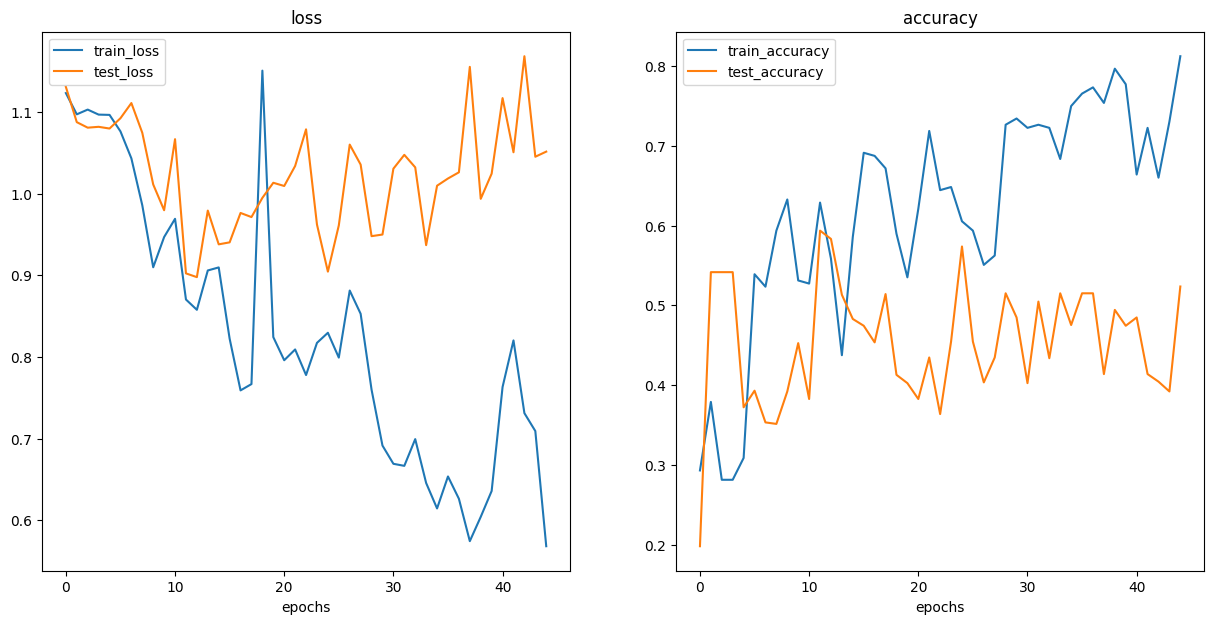

In [56]:
from scripts import utils
utils.plot_loss_curves(model_0_results)

##3.3 Training with augumented data

In [57]:
!python scripts/train.py --num_epochs 45 --batch_size 32 --hidden_units 10 --learning_rate 0.001 --transform augumented

[INFO] Training a model for 45 epochs with batch size 32 using 10 hidden units and a learning rate of 0.001
  0% 0/45 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Epoch: 1 | train_loss: 1.1108 | train_acc: 0.2539 | test_loss: 1.0949 | test_acc: 0.2604
  2% 1/45 [00:03<02:31,  3.44s/it]Epoch: 2 | train_loss: 1.0969 | train_acc: 0.3242 | test_loss: 1.0999 | test_acc: 0.2292
  4% 2/45 [00:06<02:09,  3.01s/it]Epoch: 3 | train_loss: 1.0992 | train_acc: 0.3008 | test_loss: 1.1032 | test_acc: 0.2812
  7% 3/45 [00:08<01:59,  2.84s/it]Epoch: 4 | train_loss: 1.1036 | train_acc: 0.3633 | test_loss: 1.1184 | test_acc: 0.2708
  9% 4/45 [00:11<01:52,  2.75s/it]Epoch: 5 | train_loss: 1.0968 | train_acc: 0.4219 | test_loss: 1.0869 | test_acc: 0.3731
 11% 5/45 [00:15<02:08,  3.20s/it]Epoch: 6 | train_lo

In [58]:
from scripts import model_builder, utils

model_1 = model_builder.TinyVGG(input_shape=3,
                                 hidden_units=10,
                                output_shape=3).to(device)
model_1 = utils.load_model(model=model_1, model_path="models/augumented_data_tinyvgg_model.pt")
model_1

[INFO] Loading model from: models/augumented_data_tinyvgg_model.pt


TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

##3.4 Results from training with augumented data

In [59]:
import json
model_1_results=''
with open('results/augumented_data_model_results.json', 'r') as f:
    model_1_results = json.load(f)
model_1_results

{'train_loss': [1.1108391284942627,
  1.0968628376722336,
  1.0991705060005188,
  1.1035990417003632,
  1.096759870648384,
  1.0425710454583168,
  1.086898386478424,
  1.068869560956955,
  1.0363421738147736,
  1.0759740844368935,
  1.0408783927559853,
  0.9961430355906487,
  0.9702823087573051,
  0.9551802724599838,
  1.0086125060915947,
  0.9213416278362274,
  0.9181707501411438,
  0.9269970655441284,
  1.1200891882181168,
  1.0623712986707687,
  0.9866160973906517,
  0.9703978523612022,
  1.0515524595975876,
  0.9987151473760605,
  0.936703585088253,
  0.9333503171801567,
  0.9499791488051414,
  0.874568410217762,
  0.9140523448586464,
  0.917097419500351,
  0.8122667372226715,
  0.9080331549048424,
  0.8784080743789673,
  0.8401441005989909,
  0.850387342274189,
  0.9787676557898521,
  1.0391571372747421,
  0.7997843790799379,
  0.9197660014033318,
  0.8135814256966114,
  0.9304946213960648,
  0.8260554913431406,
  0.9449315890669823,
  1.32112667709589,
  1.0021225586533546],
 'tr

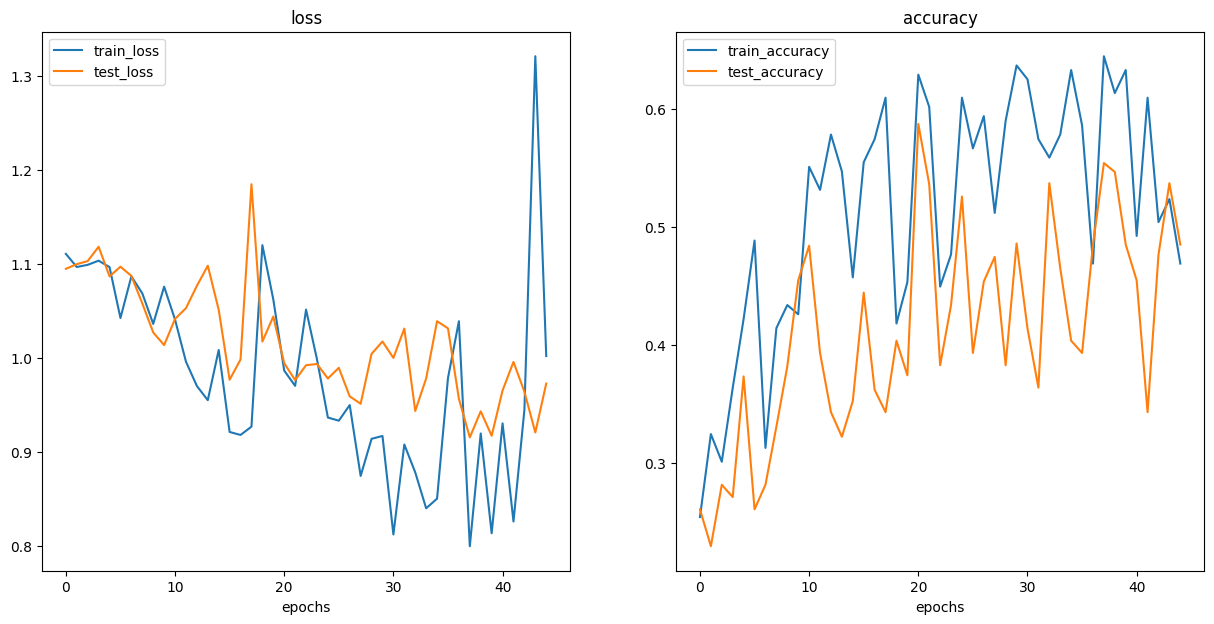

In [60]:
from scripts import utils
utils.plot_loss_curves(model_1_results)

In [61]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.123045,0.292969,1.130607,0.197917
1,1.096999,0.378906,1.087413,0.541667
2,1.102803,0.281250,1.080662,0.541667
3,1.096653,0.281250,1.081705,0.541667
4,1.096307,0.308594,1.079605,0.372159
5,1.076129,0.539062,1.092225,0.392992
6,1.043081,0.523438,1.110813,0.353220
7,0.985610,0.593750,1.074380,0.351326
8,0.909732,0.632812,1.011132,0.392045
9,0.946729,0.531250,0.979568,0.452652


#4. Comparison

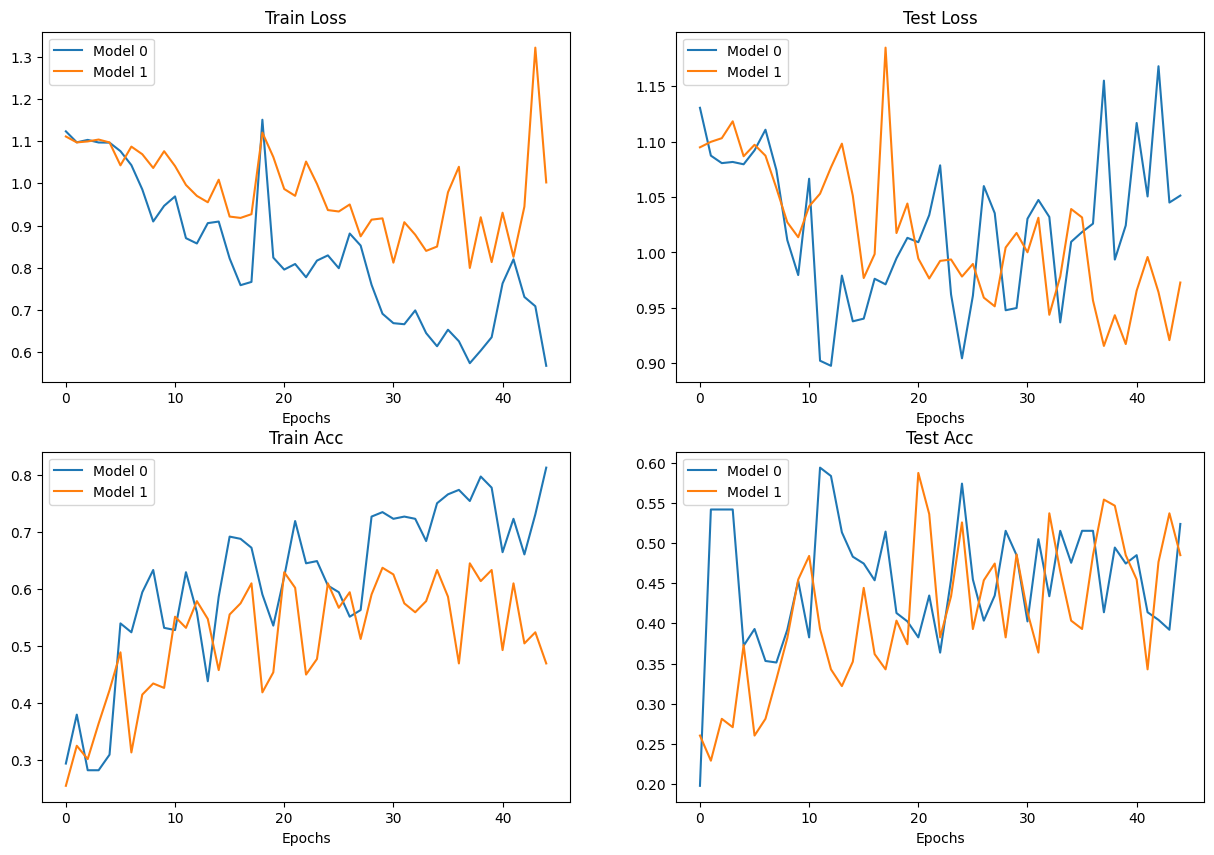

In [62]:
plt.figure(figsize=(15, 10))

epochs = range(len(model_0_df))

plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Acc")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Acc")
plt.xlabel("Epochs")
plt.legend();

#5. Prediction

##5.1 Downloading and preparing random food image from web

In [63]:
import requests

custom_image_path = data_path / "pizza.jpg"

if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    request = requests.get("https://t4.ftcdn.net/jpg/06/53/54/87/360_F_653548703_MwhAw9fCtvFSaroiErTxRM5j3LogV55c.jpg")
    print(f"downloading {custom_image_path}")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists")

data/pizza.jpg already exists


In [64]:
custom_image_path

PosixPath('data/pizza.jpg')

In [65]:
import torchvision

custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
print(f"Custom image tensor:\n {custom_image_uint8}")
print(f"Custom image shape: {custom_image_uint8.shape}")
print(f"Custom image datatype: {custom_image_uint8.dtype}")

Custom image tensor:
 tensor([[[1, 1, 1,  ..., 6, 6, 7],
         [1, 1, 1,  ..., 6, 6, 7],
         [0, 0, 0,  ..., 6, 6, 7],
         ...,
         [0, 0, 0,  ..., 2, 2, 2],
         [0, 0, 0,  ..., 5, 5, 5],
         [0, 0, 0,  ..., 5, 5, 5]],

        [[0, 0, 0,  ..., 4, 4, 5],
         [0, 0, 0,  ..., 4, 4, 5],
         [0, 0, 0,  ..., 4, 4, 5],
         ...,
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1],
         [0, 0, 0,  ..., 1, 1, 1]],

        [[0, 0, 0,  ..., 5, 5, 6],
         [0, 0, 0,  ..., 5, 5, 6],
         [0, 0, 0,  ..., 5, 5, 6],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)
Custom image shape: torch.Size([3, 360, 540])
Custom image datatype: torch.uint8


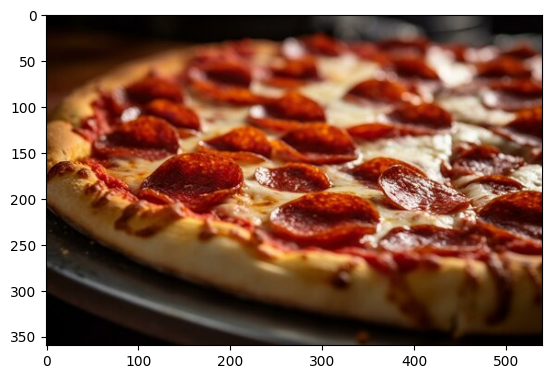

In [66]:
plt.imshow(custom_image_uint8.permute(1, 2, 0));

In [67]:
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255.
custom_image

tensor([[[0.0039, 0.0039, 0.0039,  ..., 0.0235, 0.0235, 0.0275],
         [0.0039, 0.0039, 0.0039,  ..., 0.0235, 0.0235, 0.0275],
         [0.0000, 0.0000, 0.0000,  ..., 0.0235, 0.0235, 0.0275],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0078, 0.0078, 0.0078],
         [0.0000, 0.0000, 0.0000,  ..., 0.0196, 0.0196, 0.0196],
         [0.0000, 0.0000, 0.0000,  ..., 0.0196, 0.0196, 0.0196]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0157, 0.0157, 0.0196],
         [0.0000, 0.0000, 0.0000,  ..., 0.0157, 0.0157, 0.0196],
         [0.0000, 0.0000, 0.0000,  ..., 0.0157, 0.0157, 0.0196],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039],
         [0.0000, 0.0000, 0.0000,  ..., 0.0039, 0.0039, 0.0039]],

        [[0.0000, 0.0000, 0.0000,  ..., 0.0196, 0.0196, 0.0235],
         [0.0000, 0.0000, 0.0000,  ..., 0.0196, 0.0196, 0.0235],
         [0.0000, 0.0000, 0.0000,  ..., 0.0196, 0.0196, 0.

In [68]:
from torchvision import transforms
custom_image_transform = transforms.Compose([
                                             transforms.Resize(size=(64, 64))
])

custom_image_transformed = custom_image_transform(custom_image)

print(f"original shape: {custom_image.shape}")
print(f"transformed shape: {custom_image_transformed.shape}")

original shape: torch.Size([3, 360, 540])
transformed shape: torch.Size([3, 64, 64])


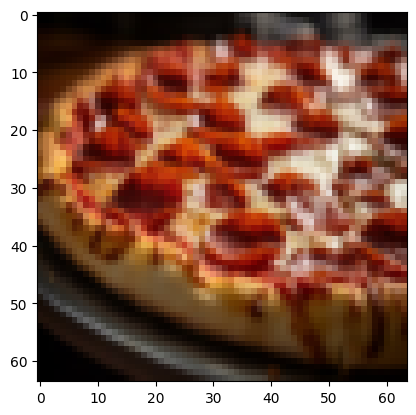

In [69]:
plt.imshow(custom_image_transformed.permute(1, 2, 0))

In [70]:
custom_image_transformed.shape, custom_image_transformed.unsqueeze(0).shape

(torch.Size([3, 64, 64]), torch.Size([1, 3, 64, 64]))

In [71]:
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.unsqueeze(0).to(device))
custom_image_pred

tensor([[ 0.3114, -1.2011,  0.1202]])

In [72]:
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

tensor([[0.4887, 0.1077, 0.4036]])

In [73]:
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1).cpu()
custom_image_pred_label

tensor([0])

In [74]:
class_names[custom_image_pred_label]

'pizza'

##5.2 Prediction test

In [75]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device=device):
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

  target_image = target_image / 255.

  if transform:
    target_image = transform(target_image)

  model.to(device)

  model.eval()
  with torch.inference_mode():
    target_image = target_image.unsqueeze(0)

    target_image_pred = model(target_image.to(device))
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  plt.imshow(target_image.squeeze().permute(1, 2, 0))
  if class_names:
    title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  else:
    title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  plt.title(title)
  plt.axis(False)

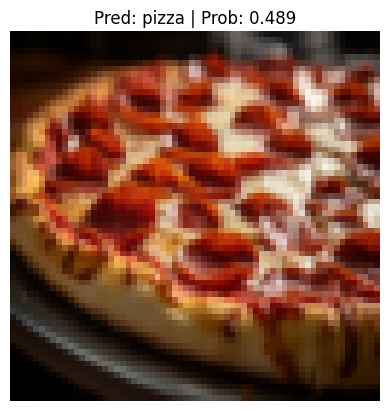

In [79]:
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=custom_image_transform,
                    device=device)

##5.3 Prediction script

In [77]:
%%writefile scripts/predict.py
import torch
import torchvision
import argparse
import model_builder


"""
Performs image classification prediction using a pre-trained PyTorch model.

This script loads a pre-trained TinyVGG model and performs a prediction on a specified image. The user can provide the image filepath and the model filepath as command-line arguments. The script is designed to work with a model trained to classify images into three categories: pizza, steak, and sushi.

Usage:
    python scripts/predict.py --image "path/to/image.jpg" --model_path "models/model_file.pt"

Arguments:
    --image (str): Filepath to the target image to predict on.
    --model_path (str): Filepath to the target model to use for prediction. Default is 'models/simple_data_tinyvgg_model.pt'.

The script will output the predicted class and the associated probability for the given image.

Example:
    python scripts/predict.py --image "data/test/pizza.jpg" --model_path "models/simple_data_tinyvgg_model.pt"
"""

parser = argparse.ArgumentParser()

parser.add_argument("--image",
                    help="target image filepath to predict on")

parser.add_argument("--model_path",
                    default="models/simple_data_tinyvgg_model.pt",
                    type=str,
                    help="target model to use for prediction filepath")

args = parser.parse_args()

class_names = ["pizza", "steak", "sushi"]

device = "cuda" if torch.cuda.is_available() else "cpu"

IMG_PATH = args.image
print(f"[INFO] Predicting on {IMG_PATH}")

def load_model(filepath=args.model_path):
  model = model_builder.TinyVGG(input_shape=3,
                                hidden_units=10,
                                output_shape=3).to(device)

  print(f"[INFO] Loading in model from: {filepath}")
  model.load_state_dict(torch.load(filepath))

  return model

def predict_on_image(image_path=IMG_PATH, filepath=args.model_path):
  model = load_model(filepath)

  image = torchvision.io.read_image(str(IMG_PATH)).type(torch.float32)

  image = image / 255.

  transform = torchvision.transforms.Resize(size=(64, 64))
  image = transform(image)

  model.eval()
  with torch.inference_mode():
    image = image.to(device)

    pred_logits = model(image.unsqueeze(dim=0))

    pred_prob = torch.softmax(pred_logits, dim=1)

    pred_label = torch.argmax(pred_prob, dim=1)
    pred_label_class = class_names[pred_label]

  print(f"[INFO] Pred class: {pred_label_class}, Pred prob: {pred_prob.max():.3f}")

if __name__ == "__main__":
  predict_on_image()

Overwriting scripts/predict.py


In [78]:
!python scripts/predict.py --image data/pizza.jpg --model_path "models/augumented_data_tinyvgg_model.pt"

[INFO] Predicting on data/pizza.jpg
[INFO] Loading in model from: models/augumented_data_tinyvgg_model.pt
[INFO] Pred class: pizza, Pred prob: 0.489
